In [ ]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pymc as pm
import arviz as az



## 1.Loading

Original datasets are divided in high and low popularity songs, but for this analysis they are combined to one dataset

In [2]:
high_popularity = pd.read_csv('../data/high_popularity_spotify_data.csv')

low_popularity = pd.read_csv('../data/low_popularity_spotify_data.csv')
songs_df = pd.concat([high_popularity, low_popularity], ignore_index=True)
songs_df.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3.0,0.0304,...,0.0000,10FLjwfpbxLmW8c25Xyc2N,0.0,6.0,251668.0,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4.0,0.0358,...,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1.0,2.0,210373.0,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4.0,0.0368,...,0.0000,0hBRqPYPXhr1RkTDG3n4Mk,1.0,1.0,166300.0,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4.0,0.0634,...,0.0000,4B4Elma4nNDUyl6D5PvQkj,0.0,0.0,157280.0,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4.0,0.2600,...,0.0000,2IYQwwgxgOIn7t3iF6ufFD,0.0,0.0,169917.0,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


## 2. Exploration

In [3]:
num_of_songs, num_of_features = songs_df.shape
print(f'Number of features: {num_of_features} \nNumber of songs: {num_of_songs}')
features = list(songs_df.columns)


Number of features: 29 
Number of songs: 4831


In [4]:
feature_description = ['A measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy', 'The speed of a track, measured in beats per minute (BPM)', 'A score describing how suitable a track is for dancing based on tempo, rhythm stability, beat strength and overall regularity', 'The main genre associated with the playlist (e.g., pop, rock, classical)', 'The overall loudness of a track in decibels (dB). Higher values indicate louder tracks overall', 'The likelihood of a track being performed live. Higher values suggest more audience presence', 'The overall musical positiveness(emotion) of a track. High valence sounds happy; low valence sounds sad or angry', 'The artist(s) performing the track', 'time signature', 'Measures the presence of spoken words', 'A score (0–100) which is calculated based on total number of streams in relation to other songs', 'track_href', 'uri', 'The album in which the track is featured', 'The name of the playlist where the track is included', 'analysis_url', 'A unique identifier assigned to the track by Spotify', 'The name of the track', 'The release date of the album containing the track', 'The likelihood a track contains no vocals. Values closer to 1.0 suggest solely instrumental tracks', 'A unique identifier for the album', 'Indicates the modality of the track', 'The musical key, represented as an integer from 0 to 11, mapping to standard Pitch class notation', 'The length of the track in milliseconds', 'A confidence measure of whether a track is acoustic(1) or not(0)', 'ID', 'A more specific subgenre tied to the playlist (e.g., indie pop, punk rock)', 'type', 'A unique identifier for the playlist']

feature_table = pd.DataFrame({
    'Feature': songs_df.columns,
    'Datentyp': songs_df.dtypes.values,
    'Beschreibung': feature_description 
})
feature_table

,Feature,Datentyp,Beschreibung
0,energy,float64,A measure of intensity and activity. Typically...
1,tempo,float64,"The speed of a track, measured in beats per mi..."
2,danceability,float64,A score describing how suitable a track is for...
3,playlist_genre,object,The main genre associated with the playlist (e...
4,loudness,float64,The overall loudness of a track in decibels (d...
5,liveness,float64,The likelihood of a track being performed live...
6,valence,float64,The overall musical positiveness(emotion) of a...
7,track_artist,object,The artist(s) performing the track
8,time_signature,float64,time signature
9,speechiness,float64,Measures the presence of spoken words


## 3. Data cleaning

check for missing values and remove them

In [5]:
print("=== Missing values===")
print("missing values per row:")
print(songs_df.isnull().sum())
rows_with_missing = songs_df[songs_df.isnull().any(axis=1)]

songs_df = songs_df.dropna()
print(f"number of rows after dropping missing values: {len(songs_df)}")

=== Missing values===
missing values per row:
energy                      1
tempo                       1
danceability                1
playlist_genre              0
loudness                    1
liveness                    1
valence                     1
track_artist                0
time_signature              1
speechiness                 1
track_popularity            0
track_href                  1
uri                         1
track_album_name            1
playlist_name               0
analysis_url                1
track_id                    0
track_name                  0
track_album_release_date    0
instrumentalness            1
track_album_id              0
mode                        1
key                         1
duration_ms                 1
acousticness                1
id                          1
playlist_subgenre           0
type                        1
playlist_id                 0
dtype: int64
number of rows after dropping missing values: 4829


check for duplicates and remove them

In [6]:
print("\n=== Using the track ID to identify duplicates  ===")
duplicates = songs_df.duplicated(subset=['track_id'])
print(f"number of duplicates: {duplicates.sum()}")
clean_songs_df = songs_df.drop_duplicates(subset=['track_id'])
print(f"number of rows after dropping duplicates: {len(songs_df)}")


=== Using the track ID to identify duplicates  ===
number of duplicates: 336
number of rows after dropping duplicates: 4829


 ## 4. Fetaure Engineering

Encode the features 'playlist_genre' and 'playlist_subgenre' to use them for classification

In [7]:
playlist_genre = clean_songs_df['playlist_genre'].value_counts().sort_index()
playlist_subgenre = clean_songs_df['playlist_subgenre'].value_counts().sort_index()
print(f'number of unique values in playlist_genre: {len(playlist_genre)}')
print(f'number of unique values in playlist_subgenre: {len(playlist_subgenre)}')
label_encoder = LabelEncoder()
clean_songs_df['playlist_genre_encoded'] = label_encoder.fit_transform(clean_songs_df['playlist_genre'])
clean_songs_df['playlist_subgenre_encoded'] = label_encoder.fit_transform(clean_songs_df['playlist_subgenre'])





number of unique values in playlist_genre: 35
number of unique values in playlist_subgenre: 84


C:\Users\jonas\AppData\Local\Temp\ipykernel_23628\928541640.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_songs_df['playlist_genre_encoded'] = label_encoder.fit_transform(clean_songs_df['playlist_genre'])
C:\Users\jonas\AppData\Local\Temp\ipykernel_23628\928541640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_songs_df['playlist_subgenre_encoded'] = label_encoder.fit_transform(clean_songs_df['playlist_subgenre'])


Create new feature and 'song_age' rearding the release date to have features with more interpretability

In [8]:

clean_songs_df['track_album_release_date'] = pd.to_datetime(clean_songs_df['track_album_release_date'], errors='coerce')


current_year = pd.to_datetime('today').year

clean_songs_df['release_year'] = clean_songs_df['track_album_release_date'].dt.year

C:\Users\jonas\AppData\Local\Temp\ipykernel_23628\816375614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_songs_df['track_album_release_date'] = pd.to_datetime(clean_songs_df['track_album_release_date'], errors='coerce')
C:\Users\jonas\AppData\Local\Temp\ipykernel_23628\816375614.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_songs_df['release_year'] = clean_songs_df['track_album_release_date'].dt.year


Now we only consider the interesting features which describe the songs in a meaningful way

In [9]:
to_drop =['track_href', 'uri', 'analysis_url', 'type', 'time_signature', 'track_album_id','track_id','track_album_name', 'id', 'playlist_id', 'track_name', 'track_album_release_date', 'track_artist', 'playlist_name', 'playlist_subgenre', 'playlist_genre']
clean_songs_df = clean_songs_df.drop(columns=to_drop)

num_of_songs, num_of_clean_features = clean_songs_df.shape
print(f'Number of features: {num_of_clean_features} \nNumber of songs: {num_of_songs}')
clean_songs_df.head()

Number of features: 16 
Number of songs: 4493


,energy,tempo,danceability,loudness,liveness,valence,speechiness,track_popularity,instrumentalness,mode,key,duration_ms,acousticness,playlist_genre_encoded,playlist_subgenre_encoded,release_year
0,0.592,157.969,0.521,-7.777,0.122,0.535,0.0304,100,0.0000,0.0,6.0,251668.0,0.3080,25,55,2024.0
1,0.507,104.978,0.747,-10.171,0.117,0.438,0.0358,97,0.0608,1.0,2.0,210373.0,0.2000,25,55,2024.0
2,0.808,108.548,0.554,-4.169,0.159,0.372,0.0368,93,0.0000,1.0,1.0,166300.0,0.2140,25,55,2024.0
3,0.910,112.966,0.670,-4.070,0.304,0.786,0.0634,81,0.0000,0.0,0.0,157280.0,0.0939,25,55,2024.0
4,0.783,149.027,0.777,-4.477,0.355,0.939,0.2600,98,0.0000,0.0,0.0,169917.0,0.0283,25,55,2024.0


Check again for any missing values

In [10]:
print("=== Missing values===")
print("missing values per row:")
print(clean_songs_df.isnull().sum())
rows_with_missing = clean_songs_df[clean_songs_df.isnull().any(axis=1)]

clean_songs_df = clean_songs_df.dropna()
print(f"number of rows after dropping missing values: {len(clean_songs_df)}")

=== Missing values===
missing values per row:
energy                         0
tempo                          0
danceability                   0
loudness                       0
liveness                       0
valence                        0
speechiness                    0
track_popularity               0
instrumentalness               0
mode                           0
key                            0
duration_ms                    0
acousticness                   0
playlist_genre_encoded         0
playlist_subgenre_encoded      0
release_year                 125
dtype: int64
number of rows after dropping missing values: 4368


Visualize the distribution of independent variables and the response variable (song popularity) for a better understanding of the data.

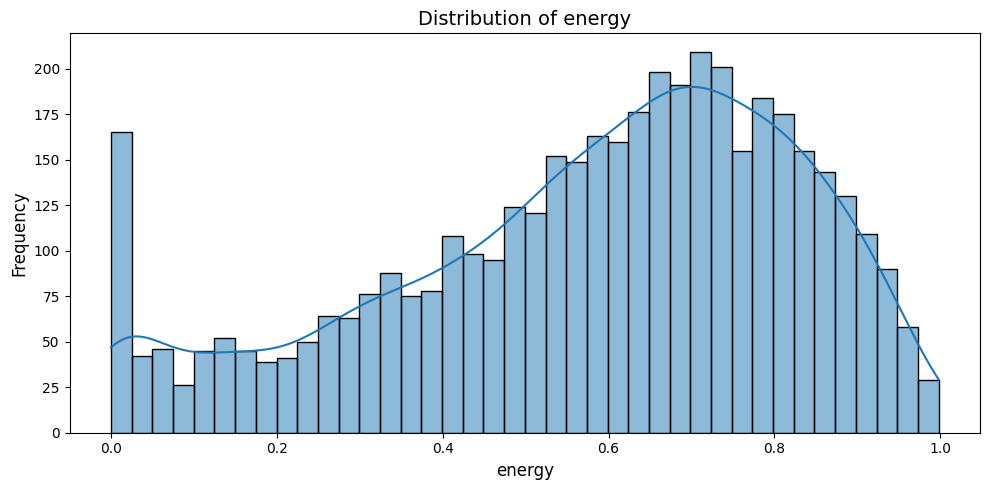

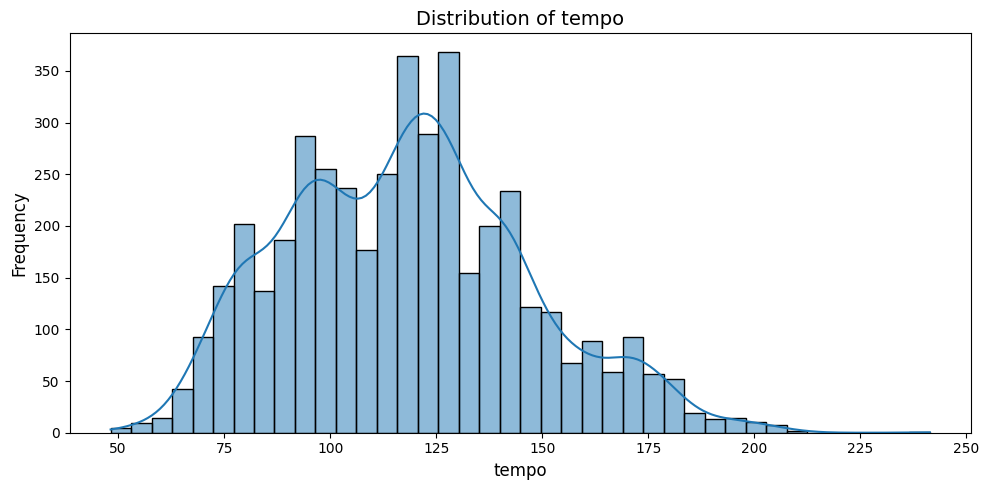

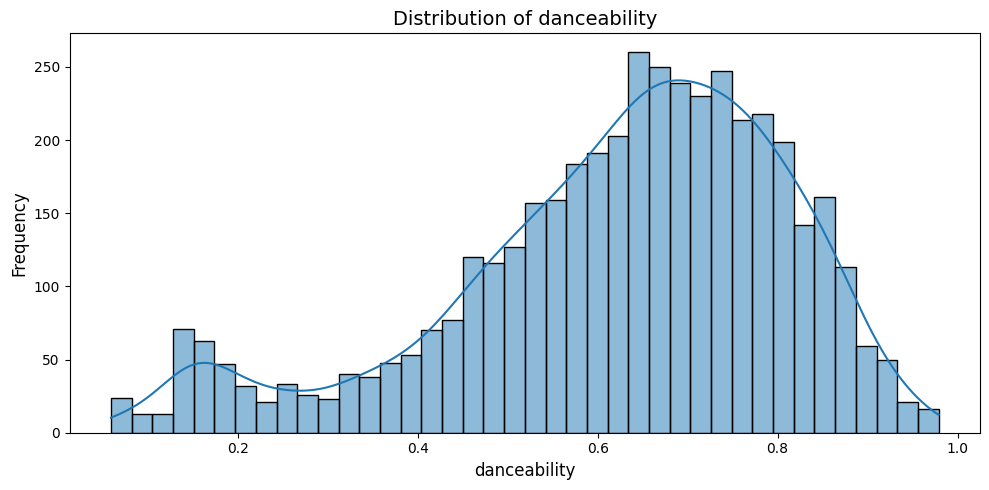

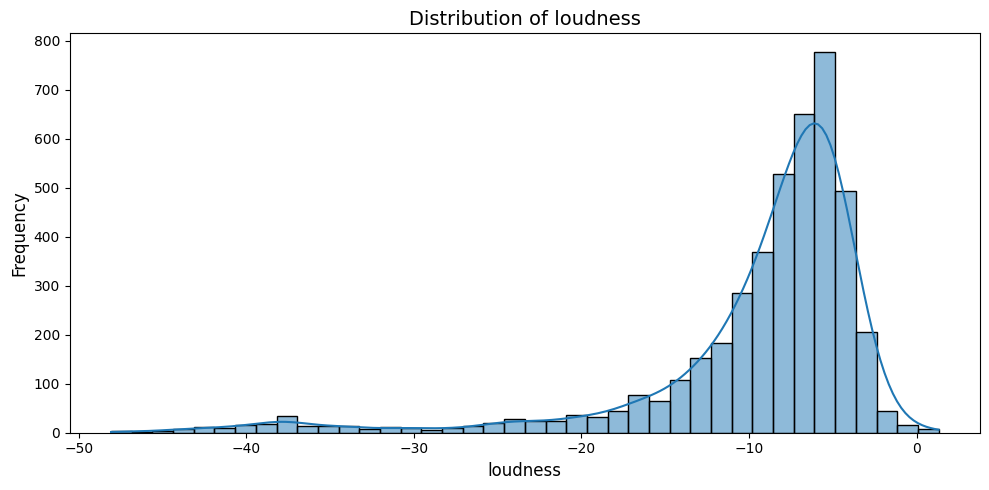

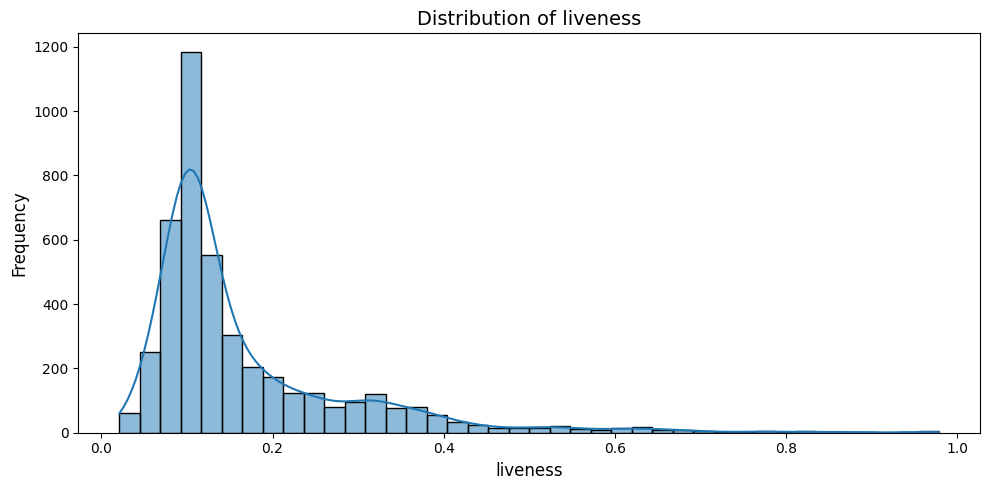

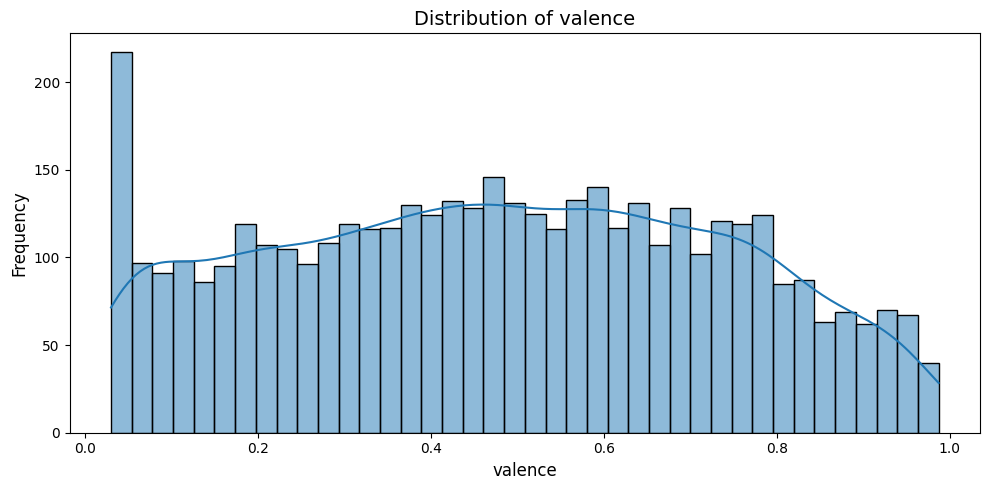

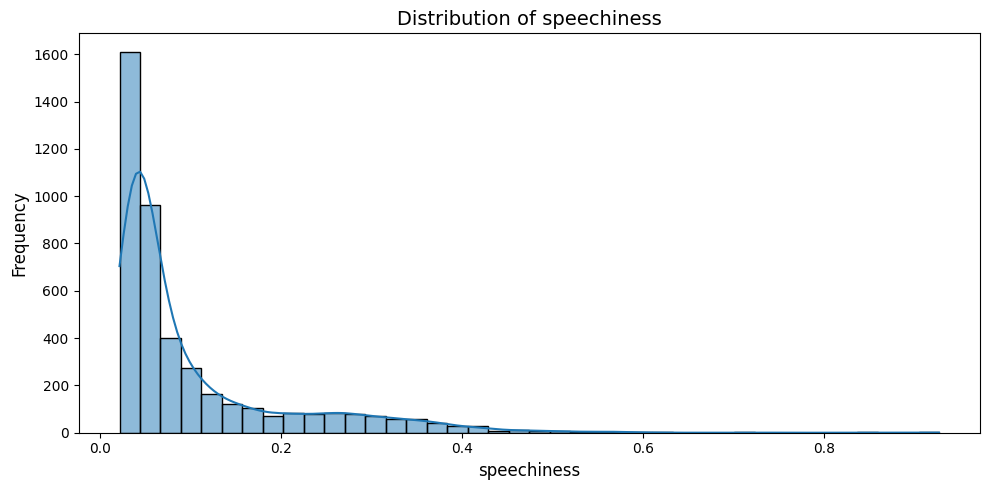

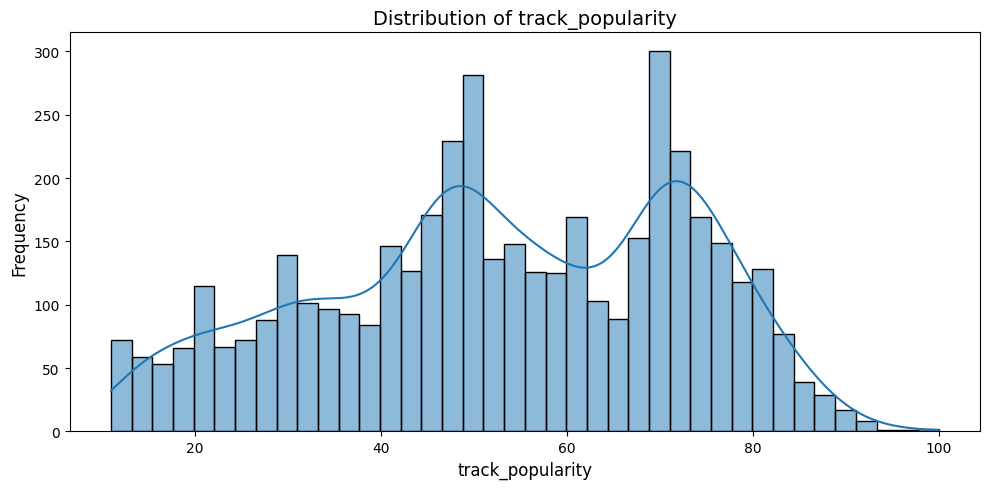

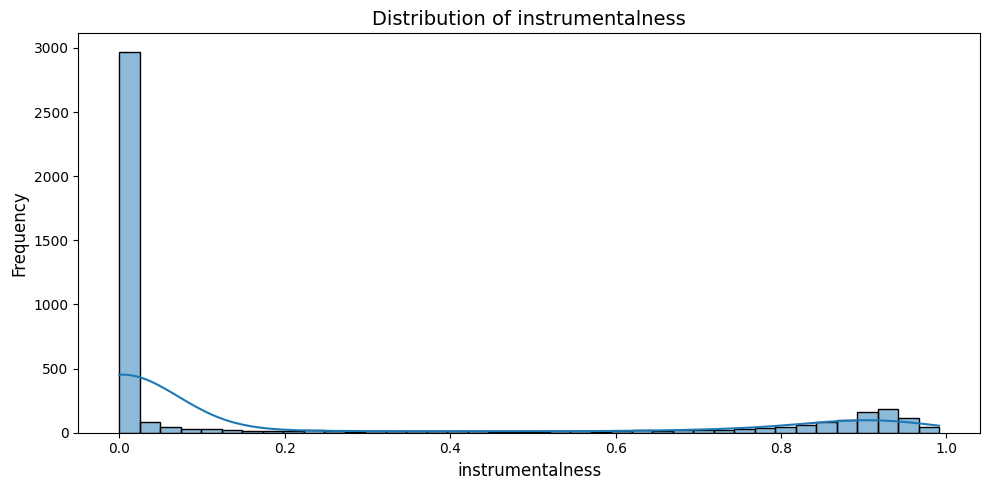

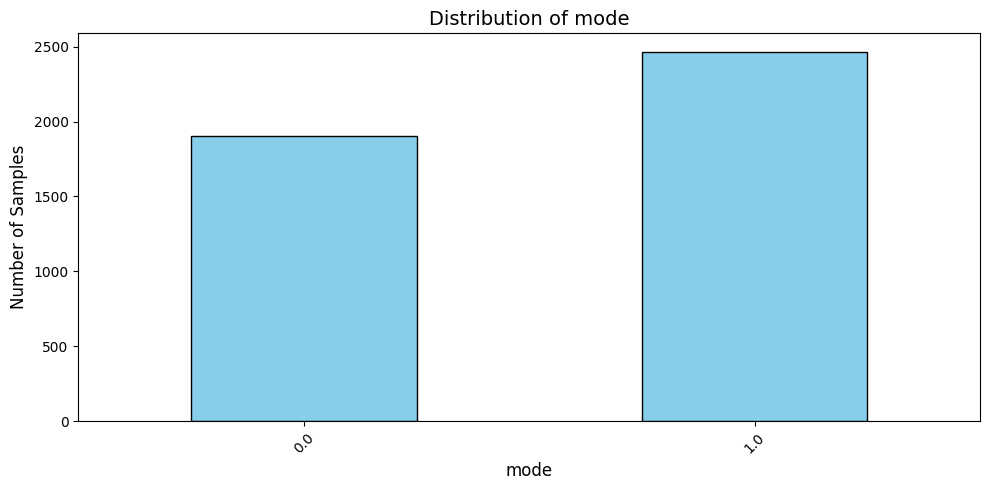

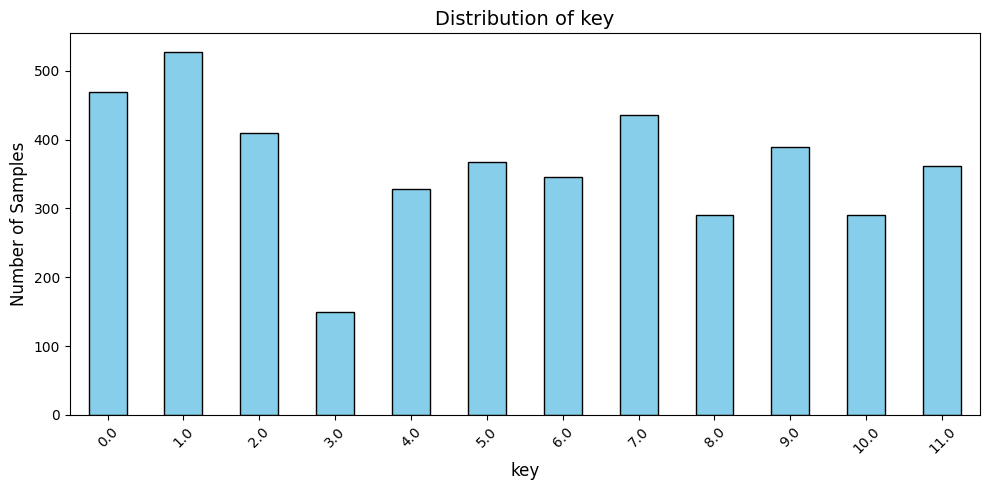

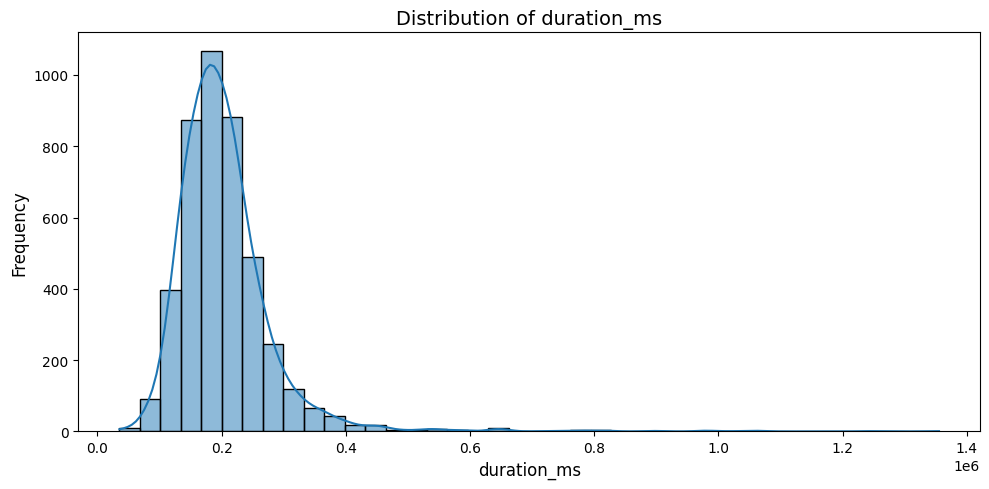

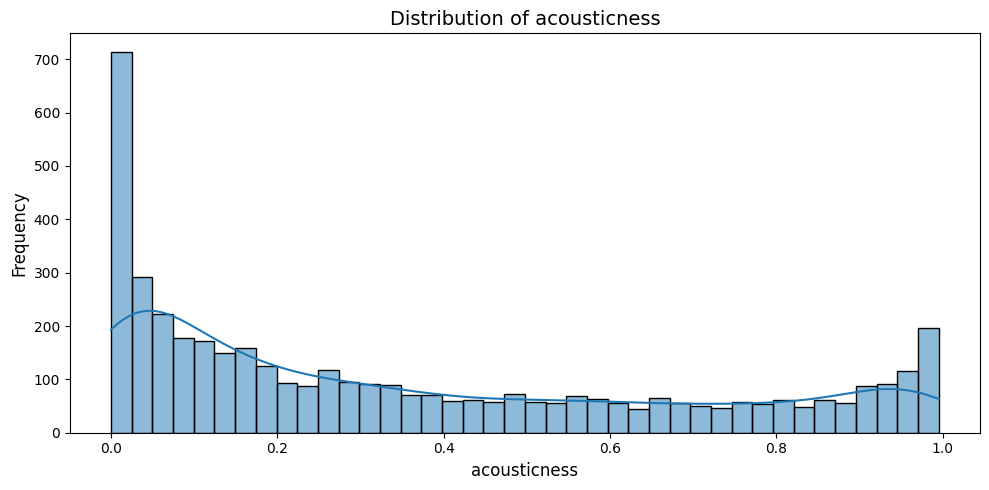

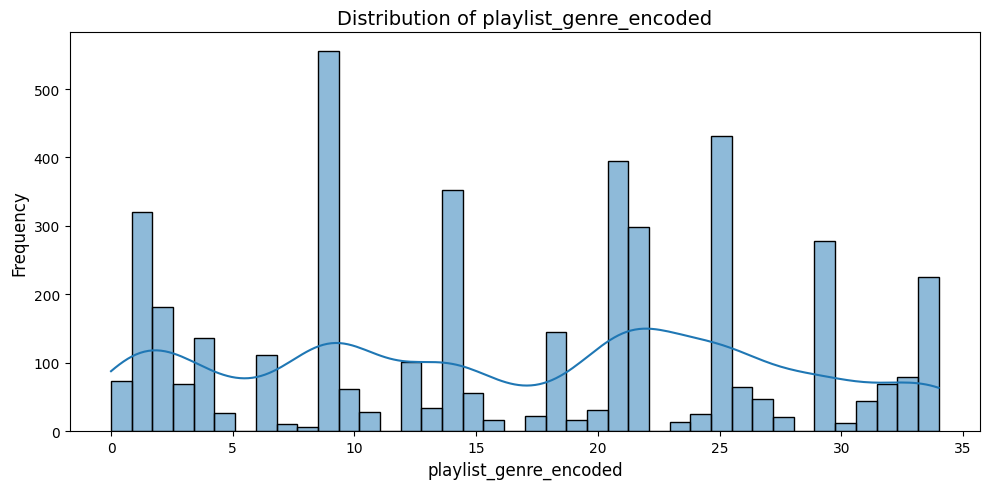

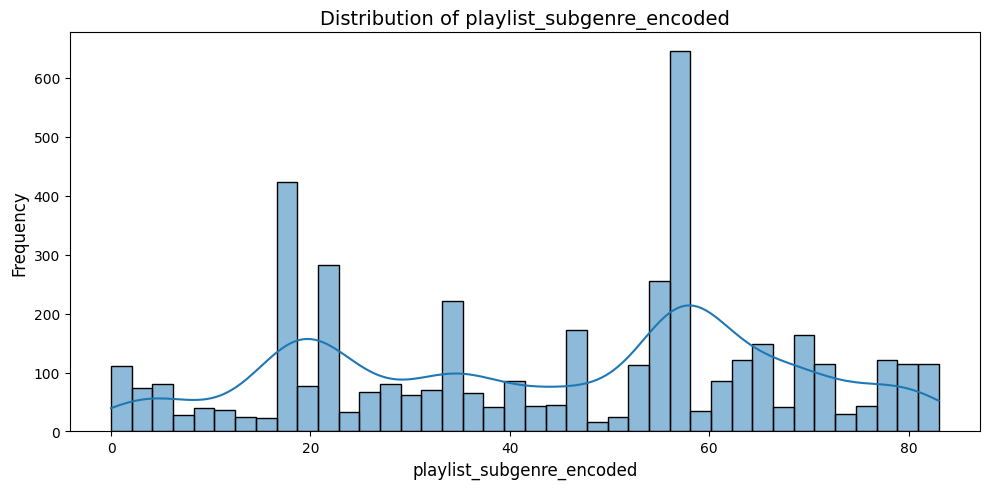

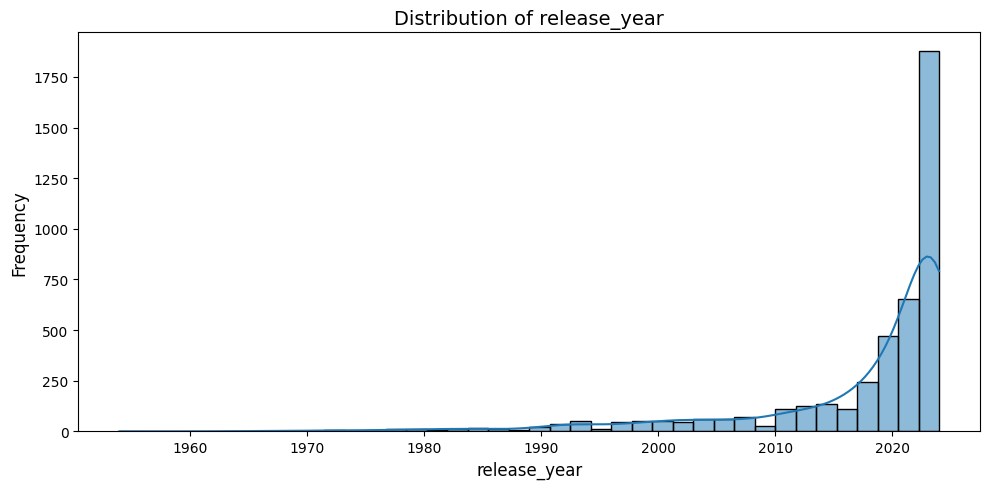

In [12]:
for col in clean_songs_df.columns:
    try:
        plt.figure(figsize=(10, 5))
        
        # Use a histogram for numeric columns with many unique values (continuous data)
        if pd.api.types.is_numeric_dtype(clean_songs_df[col]) and clean_songs_df[col].nunique() > 25:
            sns.histplot(clean_songs_df[col], kde=True, bins=40)
            plt.title(f'Distribution of {col}', fontsize=14)
            plt.xlabel(col, fontsize=12)
            plt.ylabel('Frequency', fontsize=12)
        # Use a bar chart for categorical or discrete data
        else:
            vc = clean_songs_df[col].value_counts().sort_index()
            vc.plot(kind='bar', color='skyblue', edgecolor='black')
            plt.title(f'Distribution of {col}', fontsize=14)
            plt.xlabel(col, fontsize=12)
            plt.ylabel('Number of Samples', fontsize=12)
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not plot column '{col}': {e}")

## 3. Analysis

### 3.1 Correlation analysis

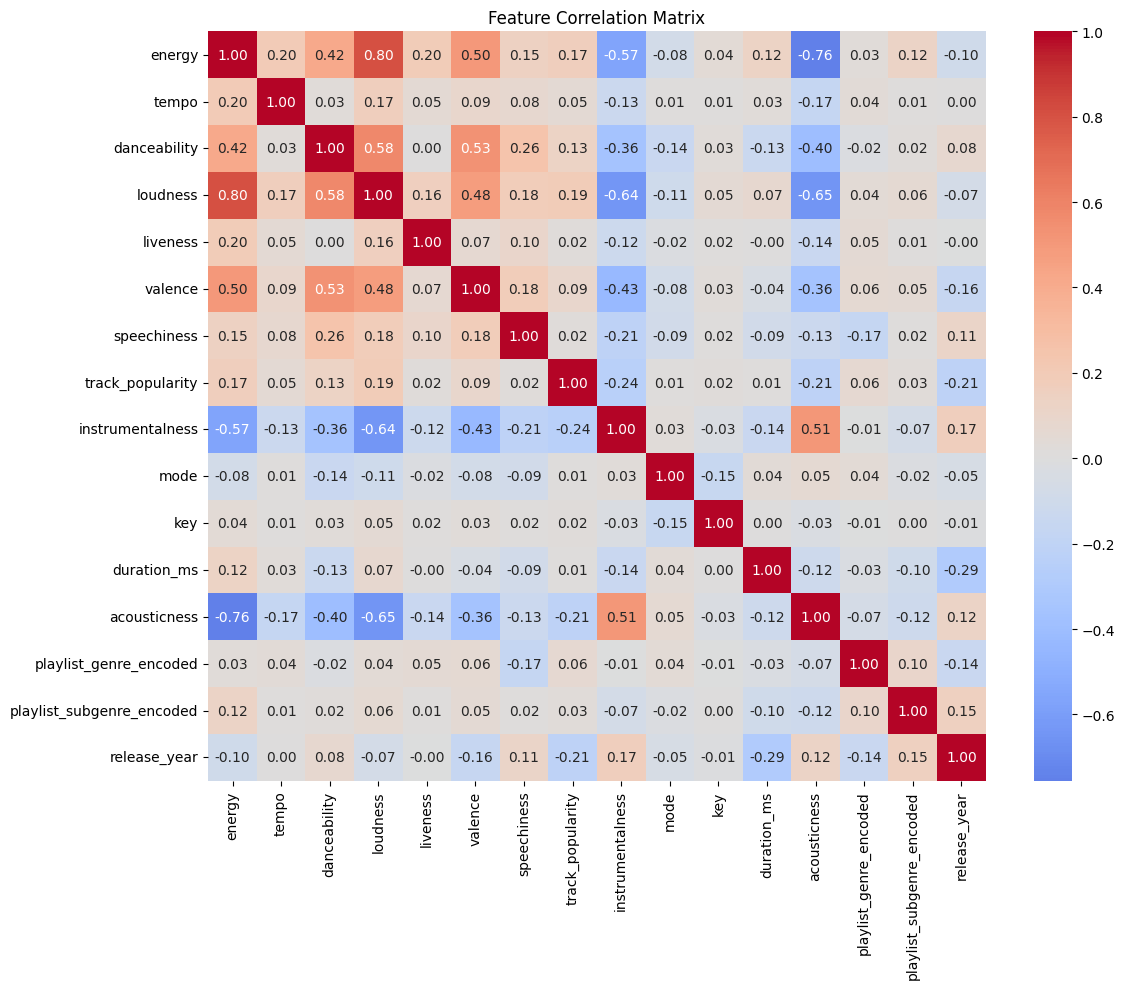

Features most correlated with track_popularity:
instrumentalness             0.241360
release_year                 0.212034
acousticness                 0.208105
loudness                     0.194624
energy                       0.167879
danceability                 0.130723
valence                      0.088401
playlist_genre_encoded       0.060880
tempo                        0.051993
playlist_subgenre_encoded    0.030876
liveness                     0.023474
speechiness                  0.022229
key                          0.022078
duration_ms                  0.009042
mode                         0.006776
Name: track_popularity, dtype: float64

Highly correlated feature pairs (>0.8):
energy - loudness: 0.802


In [13]:


# Calculate correlation matrix
corr_matrix = clean_songs_df.corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find features most correlated with target
target_correlations = corr_matrix['track_popularity'].abs().sort_values(ascending=False)
print(f"Features most correlated with {'track_popularity'}:")
print(target_correlations[1:])  # Exclude self-correlation

# Identify highly correlated feature pairs (potential multicollinearity)
high_corr_pairs = []
for i in range(len(clean_songs_df.columns)):
    for j in range(i+1, len(clean_songs_df.columns)):
        feat1, feat2 = clean_songs_df.columns[i], clean_songs_df.columns[j]
        corr_val = abs(corr_matrix.loc[feat1, feat2])
        if corr_val > 0.8:  # High correlation threshold
            high_corr_pairs.append((feat1, feat2, corr_val))

if high_corr_pairs:
    print("\nHighly correlated feature pairs (>0.8):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"{feat1} - {feat2}: {corr_val:.3f}")
else:
    print("\nNo highly correlated feature pairs found.")

As a conclusion of the correlation analysis the with loudness highly correlated feature energy will be dropped for better analysis results

In [14]:
# drop energy, because it is highly correlated with loudness
clean_songs_df = clean_songs_df.drop(columns=['energy'])


The characteristics key (key signature) and mode (major/minor) are categorical. Linear models interpret key=11 as “greater” than key=1, which makes no sense musically. One-hot coding is more suitable here.

In [15]:
# One-hot encoding for categorical features 'key' and 'mode'
key_dummies = pd.get_dummies(clean_songs_df['key'], prefix='key')
mode_dummies = pd.get_dummies(clean_songs_df['mode'], prefix='mode')

# Concatenate the one-hot encoded columns with the original DataFrame
clean_songs_df = pd.concat([clean_songs_df, key_dummies, mode_dummies], axis=1)

clean_songs_df = clean_songs_df.drop(columns=['key', 'mode'])

Create test and train set

In [16]:
target = clean_songs_df['track_popularity']

X_train, X_test, y_train, y_test = train_test_split(clean_songs_df.drop(columns=['track_popularity']), target, test_size=0.2, random_state=42,shuffle=True)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size:  {X_test.shape[0]} samples ")

#standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training set size: 3494 samples
Test set size:  874 samples 


 Testing a simple OLS model to predict the song popularity

Mean Squared Error (MSE): 355.53
Root Mean Squared Error (RMSE): 18.86
Mean Absolute Error (MAE): 15.59
R-Quadrat (R²): 0.10


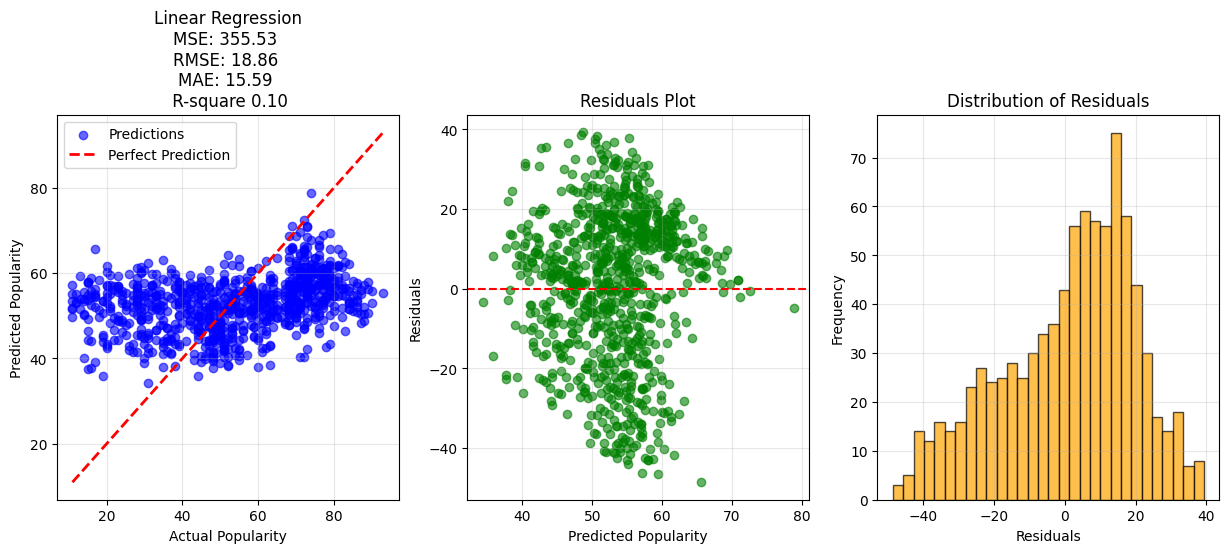

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
plt.figure(figsize=(15, 5))

rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"R-Quadrat (R²): {r2_lr:.2f}")

# Plot 1: Predictions vs Actual Values
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lr, color='blue', alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title(f'Linear Regression\nMSE: {mse_lr:.2f} \nRMSE: {rmse_lr:.2f} \nMAE: {mae_lr:.2f} \n R-square {r2_lr:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Residuals Plot
plt.subplot(1, 3, 2)
residuals_lr = y_test - y_pred_lr
plt.scatter(y_pred_lr, residuals_lr, color='green', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

# Plot 3: Distribution of Residuals
plt.subplot(1, 3, 3)
plt.hist(residuals_lr, bins=30, color='orange', alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)



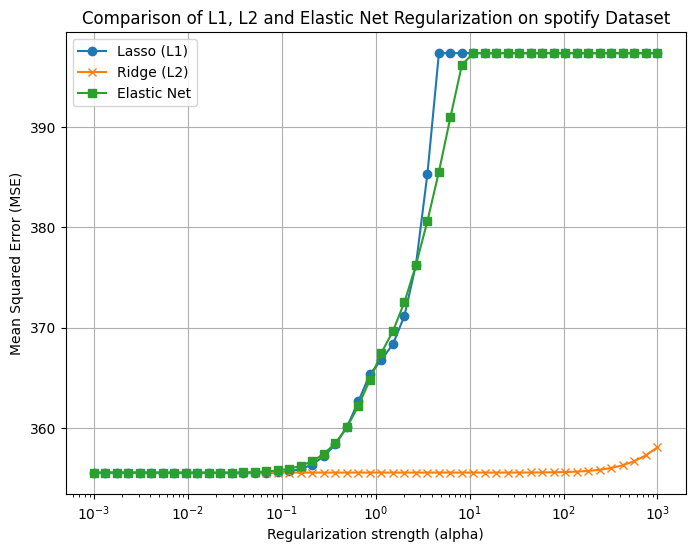


Best Lasso (L1) MSE for spotify: 355.479 at alpha=0.039
Best Ridge (L2) MSE for spotify: 355.533 at alpha=10.985
Best Elastic Net MSE for spotify: 355.525 at alpha=0.013


In [18]:
# Function to fit models and compare
alphas = np.logspace(-3, 3, 50)
lasso_mse = []
ridge_mse = []
elastic_mse = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    ridge = Ridge(alpha=alpha)
    elastic = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=10000)

    lasso.fit(X_train, y_train)
    ridge.fit(X_train, y_train)
    elastic.fit(X_train, y_train)

    y_pred_lasso = lasso.predict(X_test)
    y_pred_ridge = ridge.predict(X_test)
    y_pred_elastic = elastic.predict(X_test)

    lasso_mse.append(mean_squared_error(y_test, y_pred_lasso))
    ridge_mse.append(mean_squared_error(y_test, y_pred_ridge))
    elastic_mse.append(mean_squared_error(y_test, y_pred_elastic))

plt.figure(figsize=(8,6))
plt.plot(alphas, lasso_mse, label='Lasso (L1)', marker='o')
plt.plot(alphas, ridge_mse, label='Ridge (L2)', marker='x')
plt.plot(alphas, elastic_mse, label='Elastic Net', marker='s')
plt.xscale('log')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title(f'Comparison of L1, L2 and Elastic Net Regularization on spotify Dataset')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nBest Lasso (L1) MSE for spotify: {np.min(lasso_mse):.3f} at alpha={alphas[np.argmin(lasso_mse)]:.3f}")
print(f"Best Ridge (L2) MSE for spotify: {np.min(ridge_mse):.3f} at alpha={alphas[np.argmin(ridge_mse)]:.3f}")
print(f"Best Elastic Net MSE for spotify: {np.min(elastic_mse):.3f} at alpha={alphas[np.argmin(elastic_mse)]:.3f}")



In [19]:
#use best alpha values for models
lasso = Lasso(alpha=alphas[np.argmin(lasso_mse)], max_iter=10000)
ridge = Ridge(alpha=alphas[np.argmin(ridge_mse)])
elastic = ElasticNet(alpha=alphas[np.argmin(elastic_mse)], l1_ratio=0.5, max_iter=10000)

lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
elastic.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_elastic = elastic.predict(X_test)

mse_lasso=mean_squared_error(y_test, y_pred_lasso)
mse_ridge=mean_squared_error(y_test, y_pred_ridge)
mse_elastic=mean_squared_error(y_test, y_pred_elastic)

rmse_lasso = np.sqrt(mse_lasso)
rmse_ridge = np.sqrt(mse_ridge)
rmse_elastic = np.sqrt(mse_elastic)

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mae_elastic = mean_absolute_error(y_test, y_pred_elastic)

r2_lasso = r2_score(y_test, y_pred_lasso)
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_elastic = r2_score(y_test, y_pred_elastic)



residuals_lasso = y_test - y_pred_lasso
residuals_ridge = y_test - y_pred_ridge
residuals_elastic = y_test - y_pred_elastic


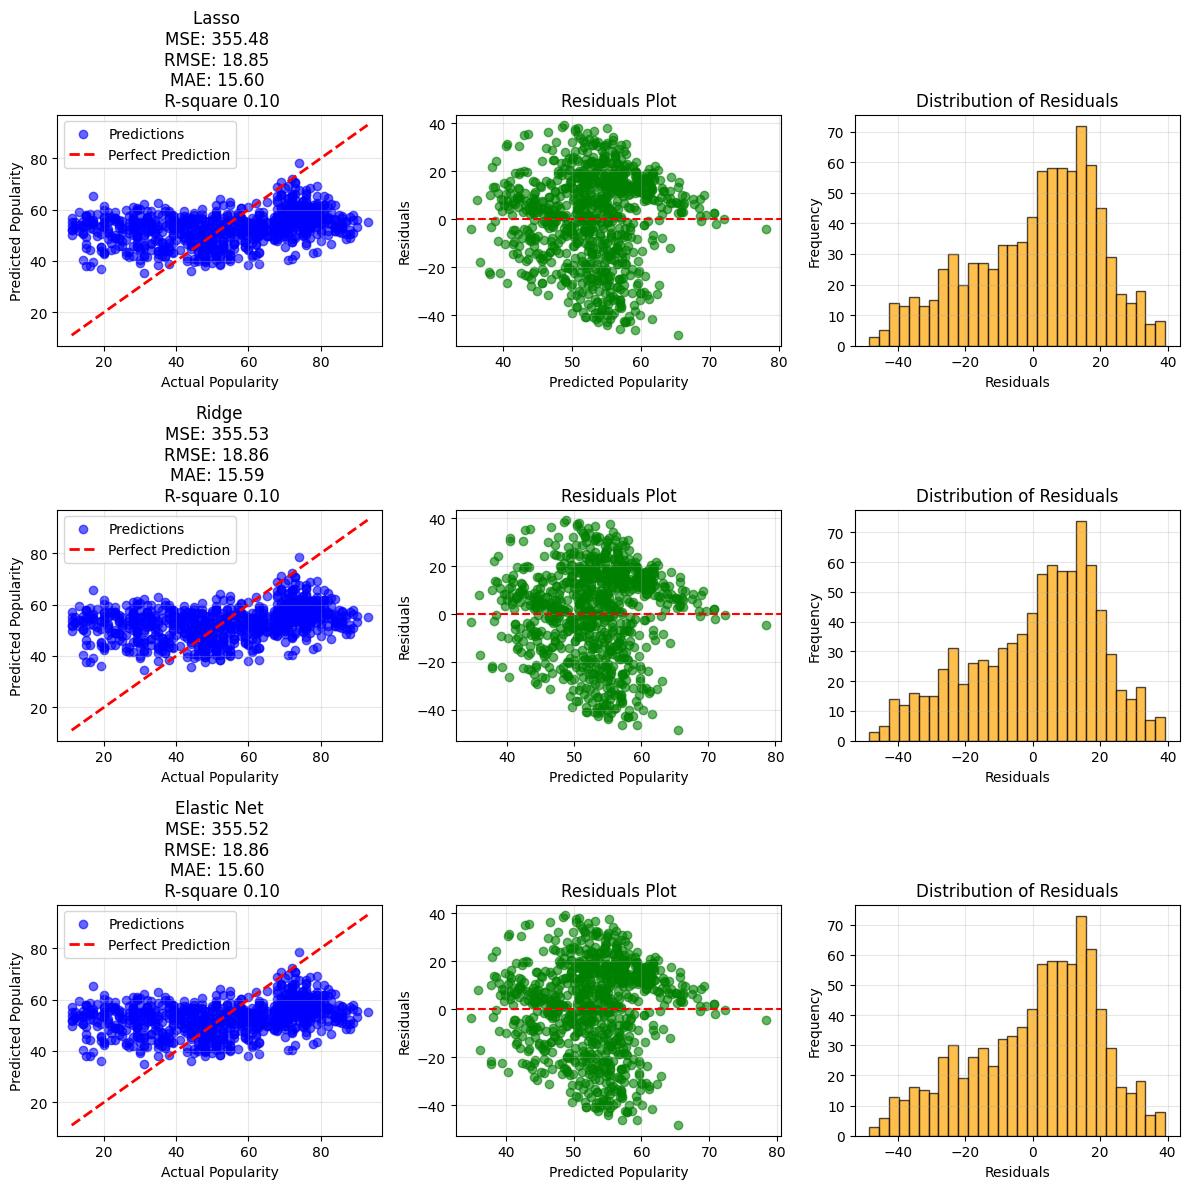

In [20]:

plt.figure(figsize=(12, 12))

#LASSO
# Plot 1: Predictions vs Actual Values
plt.subplot(3, 3, 1)
plt.scatter(y_test, y_pred_lasso, color='blue', alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title(f'Lasso \nMSE: {mse_lasso:.2f} \nRMSE: {rmse_lasso:.2f} \nMAE: {mae_lasso:.2f} \n R-square {r2_lasso:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)



# Plot 2: Residuals Plot
plt.subplot(3, 3, 2)

plt.scatter(y_pred_lasso, residuals_lasso, color='green', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

# Plot 3: Distribution of Residuals
plt.subplot(3, 3, 3)
plt.hist(residuals_lasso, bins=30, color='orange', alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

#RIDGE
# Plot 1: Predictions vs Actual Values
plt.subplot(3, 3, 4)
plt.scatter(y_test, y_pred_ridge, color='blue', alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title(f'Ridge\nMSE: {mse_ridge:.2f} \nRMSE: {rmse_ridge:.2f} \nMAE: {mae_ridge:.2f} \n R-square {r2_ridge:.2f}')

plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Residuals Plot
plt.subplot(3, 3, 5)

plt.scatter(y_pred_ridge, residuals_ridge, color='green', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

# Plot 3: Distribution of Residuals
plt.subplot(3, 3, 6)
plt.hist(residuals_ridge, bins=30, color='orange', alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

#ELASTIC
# Plot 1: Predictions vs Actual Values
plt.subplot(3, 3, 7)
plt.scatter(y_test, y_pred_elastic, color='blue', alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title(f'Elastic Net\nMSE: {mse_elastic:.2f} \nRMSE: {rmse_elastic:.2f} \nMAE: {mae_elastic:.2f} \n R-square {r2_elastic:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Residuals Plot
plt.subplot(3, 3, 8)

plt.scatter(y_pred_elastic, residuals_elastic, color='green', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

# Plot 3: Distribution of Residuals
plt.subplot(3, 3, 9)
plt.hist(residuals_elastic, bins=30, color='orange', alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# 1. Random Forest Regressor
print("\n--- Random Forest ---")
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
residuals_rf = y_test - y_pred_rf
print(f"Mean Squared Error for Random Forest: {mse_rf:.2f}")



# Metriken berechnen
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"R-Quadrat (R²): {r2_rf:.2f}")




--- Random Forest ---
Mean Squared Error for Random Forest: 158.56
Mean Squared Error (MSE): 158.56
Root Mean Squared Error (RMSE): 12.59
Mean Absolute Error (MAE): 9.28
R-Quadrat (R²): 0.60


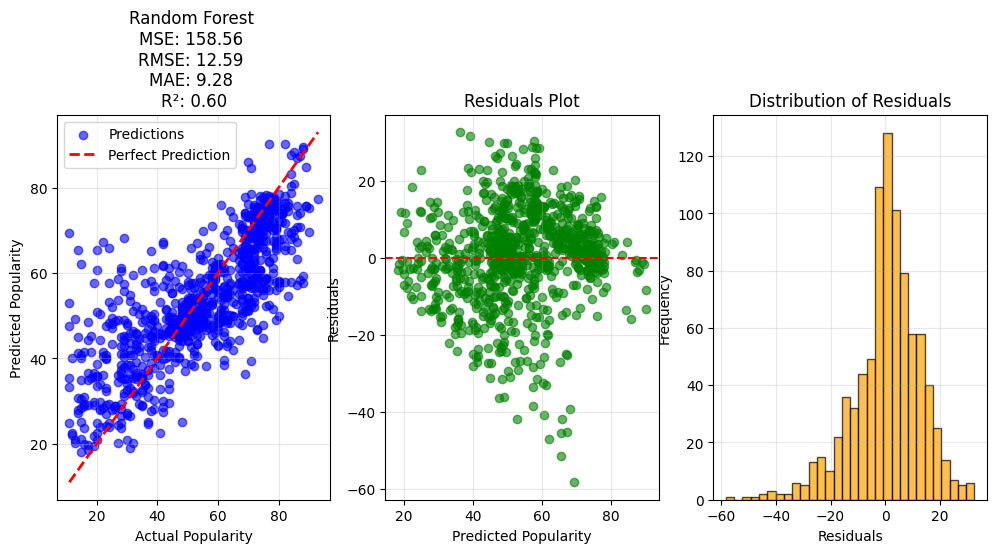

In [ ]:
plt.figure(figsize=(12, 5))

#LRandom Forest
# Plot 1: Predictions vs Actual Values
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title(f'Random Forest \nMSE: {mse_rf:.2f} \nRMSE: {rmse_rf:.2f} \nMAE: {mae_rf:.2f} \nR²: {r2_rf:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)



# Plot 2: Residuals Plot
plt.subplot(1, 3, 2)

plt.scatter(y_pred_rf, residuals_rf, color='green', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

# Plot 3: Distribution of Residuals
plt.subplot(1, 3, 3)
plt.hist(residuals_rf, bins=30, color='orange', alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)



## Bayesian Regression

In [24]:
## Bayessche Regression

print("--- Bayessian Regression ---")
print(f"Number of Features: {X_train.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Modell definieren
with pm.Model() as bayesian_model:
    # Shared variables für die Daten (ermöglicht später das Ändern der Daten)
    X_shared = pm.Data("X_shared", X_train)

    # Priors für die Regressionskoeffizienten
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_train.shape[1])
    intercept = pm.Normal('intercept', mu=0, sigma=10)

    # Fehlerterm (Rauschen)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Lineare Prädiktion
    mu = intercept + pm.math.dot(X_shared, beta)

    # Likelihood: Beobachtete Popularität
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

    # Posterior-Sampling
    print("Start MCMC Sampling...")
    trace = pm.sample(1000, tune=1000, target_accept=0.95, random_seed=42, cores=1)

print("Sampling finished!")

--- Bayessian Regression ---
Number of Features: 26
Training samples: 3494
Test samples: 874


NameError: name 'pm' is not defined


--- Modell-Diagnostik ---


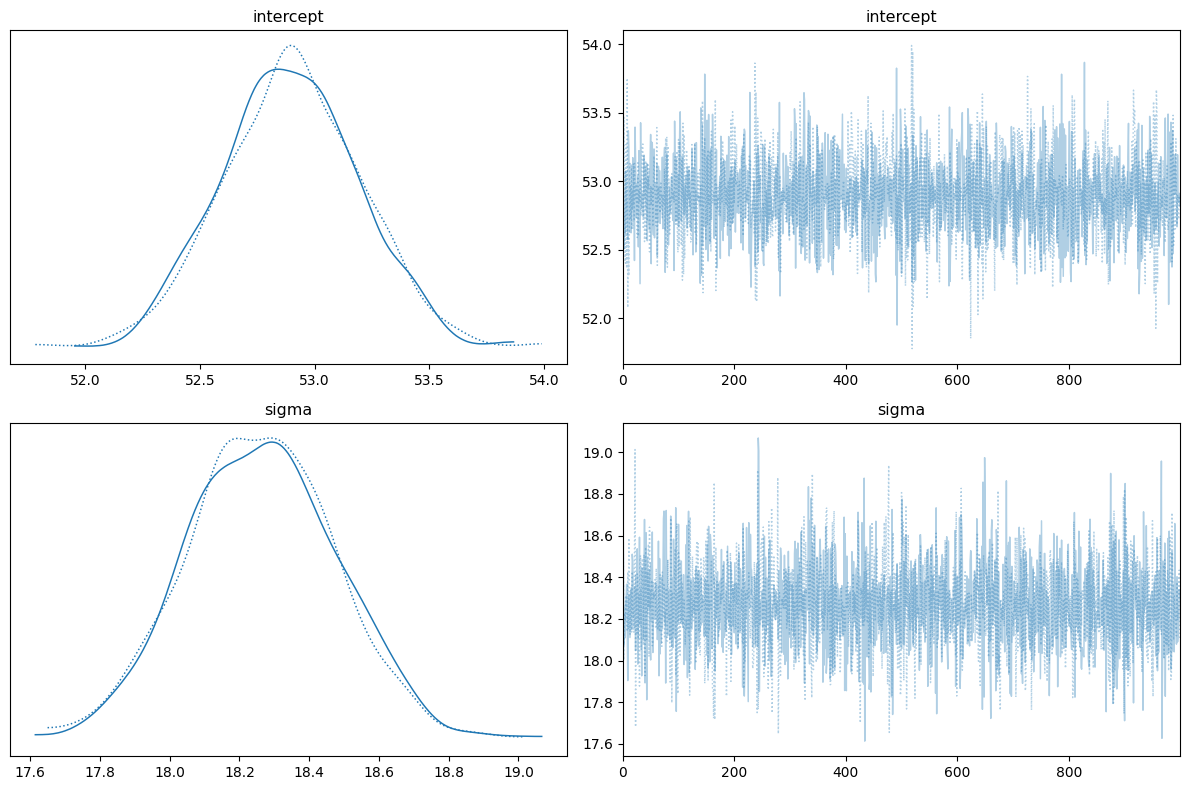

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  52.898  0.301  52.319   53.428      0.005    0.008    3509.0   
sigma      18.264  0.217  17.883   18.690      0.003    0.005    3939.0   

           ess_tail  r_hat  
intercept    1386.0    1.0  
sigma        1392.0    1.0  


In [ ]:
# Modell-Diagnostik
print("\n--- Modell-Diagnostik ---")

# Trace-Plot für wichtige Parameter
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
pm.plot_trace(trace, var_names=['intercept', 'sigma'], axes=axes)
plt.tight_layout()
plt.show()

# Zusammenfassung der Posterior-Verteilungen
print(az.summary(trace, var_names=['intercept', 'sigma']))

In [ ]:
# Vorhersagen für Testdaten generieren
print("\n--- Generate predictions ---")

# Posterior-Samples extrahieren
beta_samples = trace.posterior['beta'].values.reshape(-1, X_train.shape[1])
intercept_samples = trace.posterior['intercept'].values.flatten()
sigma_samples = trace.posterior['sigma'].values.flatten()

print(f"Beta samples shape: {beta_samples.shape}")
print(f"Intercept samples shape: {intercept_samples.shape}")

# Vorhersagen für Testdaten berechnen
n_posterior_samples = beta_samples.shape[0]
y_pred_samples = []

for i in range(n_posterior_samples):
    # Deterministischer Teil der Vorhersage
    mu_test = intercept_samples[i] + X_test @ beta_samples[i]
    # Stochastischer Teil (Rauschen hinzufügen)
    y_pred_sample = np.random.normal(mu_test, sigma_samples[i])
    y_pred_samples.append(y_pred_sample)

y_pred_samples = np.array(y_pred_samples)

# Vorhersage-Statistiken berechnen
y_pred_bayes_mean = y_pred_samples.mean(axis=0)
y_pred_bayes_std = y_pred_samples.std(axis=0)

# Metriken berechnen
mse_bayes = mean_squared_error(y_test, y_pred_bayes_mean)
rmse_bayes = np.sqrt(mse_bayes)
mae_bayes = mean_absolute_error(y_test, y_pred_bayes_mean)
r2_bayes = r2_score(y_test, y_pred_bayes_mean)

print(f"Bayesian Regression Metriken:")
print(f"MSE: {mse_bayes:.2f}")
print(f"RMSE: {rmse_bayes:.2f}")
print(f"MAE: {mae_bayes:.2f}")
print(f"R²: {r2_bayes:.2f}")


--- Vorhersagen generieren ---
Beta samples shape: (2000, 14)
Intercept samples shape: (2000,)
Bayesian Regression Metriken:
MSE: 356.90
RMSE: 18.89
MAE: 15.65
R²: 0.10


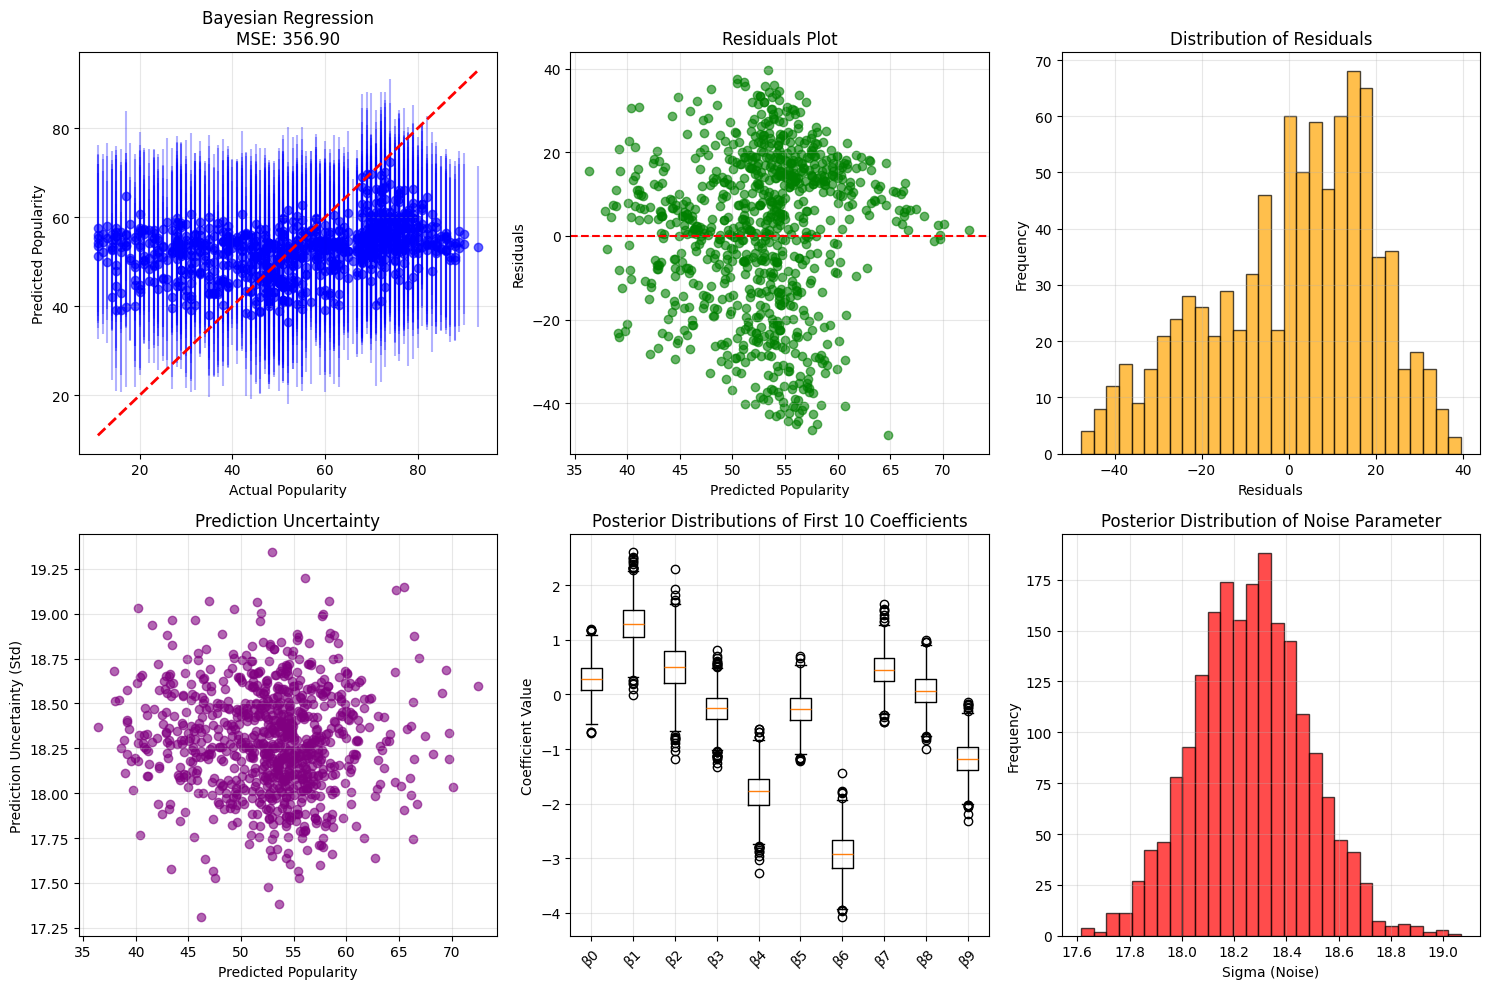

In [ ]:
# Unsicherheitsquantifizierung und Visualisierung
residuals_bayes = y_test - y_pred_bayes_mean

plt.figure(figsize=(15, 10))

# Plot 1: Predictions vs Actual mit Unsicherheitsbändern
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_bayes_mean, color='blue', alpha=0.6)
plt.errorbar(y_test, y_pred_bayes_mean, yerr=y_pred_bayes_std,
             fmt='none', alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title(f'Bayesian Regression\nMSE: {mse_bayes:.2f}\nRMSE: {rmse_bayes:.2f} \nMAE: {mae_bayes:.2f} \nR²: {r2_bayes:.2f}')
plt.grid(True, alpha=0.3)

# Plot 2: Residuals
plt.subplot(2, 3, 2)
plt.scatter(y_pred_bayes_mean, residuals_bayes, color='green', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

# Plot 3: Residuals Verteilung
plt.subplot(2, 3, 3)
plt.hist(residuals_bayes, bins=30, color='orange', alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

# Plot 4: Unsicherheit vs Vorhersage
plt.subplot(2, 3, 4)
plt.scatter(y_pred_bayes_mean, y_pred_bayes_std, color='purple', alpha=0.6)
plt.xlabel('Predicted Popularity')
plt.ylabel('Prediction Uncertainty (Std)')
plt.title('Prediction Uncertainty')
plt.grid(True, alpha=0.3)

# Plot 5: Posterior der ersten 10 Koeffizienten
plt.subplot(2, 3, 5)
n_features_to_show = min(10, X_train.shape[1])
plt.boxplot(beta_samples[:, :n_features_to_show],
           labels=[f'β{i}' for i in range(n_features_to_show)])
plt.xticks(rotation=45)
plt.ylabel('Coefficient Value')
plt.title('Posterior Distributions of First 10 Coefficients')
plt.grid(True, alpha=0.3)

# Plot 6: Sigma Posterior
plt.subplot(2, 3, 6)
plt.hist(sigma_samples, bins=30, alpha=0.7, color='red', edgecolor='black')
plt.xlabel('Sigma (Noise)')
plt.ylabel('Frequency')
plt.title('Posterior Distribution of Noise Parameter')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


--- Konfidenzintervalle ---


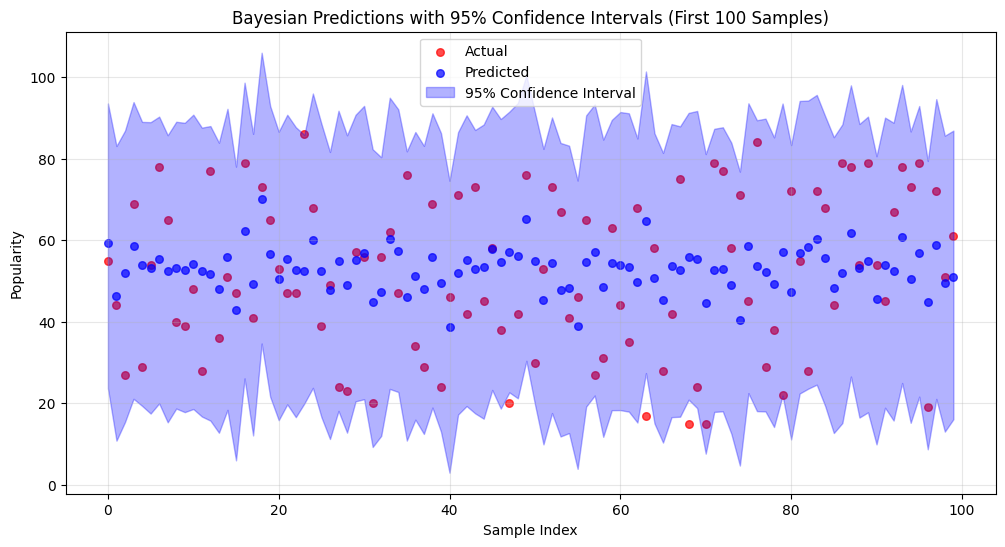

Tatsächliche Abdeckung der 95% Konfidenzintervalle: 94.6%


In [ ]:
# Konfidenzintervalle für Vorhersagen
print("\n--- Konfidenzintervalle ---")

# 95% Konfidenzintervalle berechnen
ci_lower = np.percentile(y_pred_samples, 2.5, axis=0)
ci_upper = np.percentile(y_pred_samples, 97.5, axis=0)

# Visualisierung der ersten 100 Vorhersagen mit Konfidenzintervallen
plt.figure(figsize=(12, 6))
x_indices = np.arange(min(100, len(y_test)))
plt.scatter(x_indices, y_test.iloc[:len(x_indices)], color='red', alpha=0.7, label='Actual', s=30)
plt.scatter(x_indices, y_pred_bayes_mean[:len(x_indices)], color='blue', alpha=0.7, label='Predicted', s=30)
plt.fill_between(x_indices, ci_lower[:len(x_indices)], ci_upper[:len(x_indices)],
                 alpha=0.3, color='blue', label='95% Confidence Interval')
plt.xlabel('Sample Index')
plt.ylabel('Popularity')
plt.title('Bayesian Predictions with 95% Confidence Intervals (First 100 Samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Prozentsatz der Vorhersagen innerhalb der Konfidenzintervalle
within_ci = np.sum((y_test >= ci_lower) & (y_test <= ci_upper))
coverage = within_ci / len(y_test) * 100
print(f"Tatsächliche Abdeckung der 95% Konfidenzintervalle: {coverage:.1f}%")